# 📦 Dependencias Requeridas

Este bloque importa las bibliotecas esenciales para la simulación de la dinámica de los tanques, el procesamiento de datos y la implementación de la Red Neuronal Informada por Físicas (PINN).

| Dependencia | Módulo Específico | Propósito |
| :--- | :--- | :--- |
| **`numpy`** | - | Soporte fundamental para operaciones numéricas y vectoriales. |
| **`scipy`** | `solve_ivp` | Solución numérica de **EDOs** (datos base). |
| **`scipy`** | `interp1d` | Creación de funciones de **interpolación** para la entrada $u(t)$. |
| **`matplotlib`** | `pyplot` | **Visualización** de resultados y comparación de modelos. |
| **`torch`** | - | Biblioteca principal para la construcción del modelo **PINN**. |
| **`torch.nn`** | `nn` | Módulos de capas y funciones de activación para la arquitectura de la **Red Neuronal**. |
| **`torch.optim`** | `optim` | Algoritmos de **optimización** (entrenamiento). |
| **`torch.autograd`** | `grad` | Cálculo de **derivadas automáticas** (requerido para la pérdida física). |

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

# ⚙️ Parámetros Físicos y de Simulación

Este bloque define las constantes físicas del sistema de tanques acoplados y los parámetros de la discretización temporal utilizados para la simulación numérica.

### Parámetros Físicos del Sistema (SI)

Los modelos dinámicos se basan en la ecuación de Bernoulli y la ley de Torricelli para describir el flujo de agua entre los tanques.

| Variable | Unidad de medida | Descripción |
| :--- | :----- | :--- |
| **A** | $\text{m}^2$ | Área transversal de los tanques (asumidos idénticos). |
| **a1** | $\text{m}^2$ | Área del orificio de salida del Tanque 1. |
| **a2** | $\text{m}^2$ | Área del orificio de salida del Tanque 2. |
| **g** | $\text{m}/\text{s}^2$ | Constante de la aceleración de la gravedad. |
| **eta** | $\text{m}^3/(\text{s}\cdot\text{V})$ | Constante de caudal volumétrico de la bomba. |

La dinámica de la altura $h_i$ se rige por el balance de masas, donde la variación de volumen es proporcional al flujo neto:

$$
A \frac{dh_i}{dt} = Q_{in, i} - Q_{out, i}
$$

El flujo de salida por orificio sigue la ley de Torricelli: $Q_{out} = a \sqrt{2g h}$.

### Parámetros de Simulación y Ruido

| Variable | Unidad de medida | Descripción |
| :--- | :--- | :--- |
| **dt** | $\text{s}$ | Intervalo de muestreo ($T_s$) para la simulación numérica. |
| **T\_sim** | $\text{s}$ | Duración total de la simulación del sistema. |
| **h0** | $\text{m}$ | Estado inicial del sistema: $\mathbf{h}(0)$. |
| **noise\_input\_std** | $\text{V}$ | Desviación estándar ($\sigma$) del ruido Gaussiano agregado a la entrada de control $u(t)$. |
| **noise\_output\_std** | $\text{m}$ | Desviación estándar ($\sigma$) del ruido Gaussiano agregado a las alturas medidas $h_i(t)$. |
| **t_cambio** | $\text{s}$ | Intervalo de tiempo para el cambio de voltaje a la entrada de control $u(t)$ |
| **V_min** | $\text{V}$ | Valor mínimo posible de la entrada de control $u(t)$ |
| **V_max** | $\text{V}$ | Valor máximo posible de la entrada de control $u(t)$ |

In [2]:
# Parámetros físicos del sistema en unidades SI
A = 28e-4
a1 = 0.071e-4
a2 = a1
g = 9.81
eta = 0.5e-5

# Tiempo de simulación y condiciones iniciales
dt = 0.05
T_sim = 600
t = np.arange(0, T_sim + dt, dt)  # Vector de tiempo discreto
n = len(t)                        # Número total de puntos muestreados
h0 = np.array([0.0, 0.0])         # Alturas iniciales de los tanques [m]

# Ruido y parámetros de la Señal
noise_input_std = 0
noise_output_std = 0
t_cambio = 20
V_min = 0
V_max = 2.0

# 🌊 Modelo Dinámico No Lineal del Sistema de Tanques

La función `nonlinear_ode_system_model` implementa el conjunto de Ecuaciones Diferenciales Ordinarias (EDOs) que describen la dinámica de las alturas de los tanques ($\mathbf{h} = [h_1, h_2]^T$) basándose en el balance de masa.

### Ecuaciones Fundamentales

El modelo se basa en la Ley de Torricelli, que establece que la velocidad de salida de un fluido por un orificio es proporcional a la raíz cuadrada de la altura.

La formulación general para el tanque $i$ es:
$$
A \frac{dh_i}{dt} = Q_{in, i} - Q_{out, i}
$$

### 1. Dinámica del Tanque 1 ($h_1$)

$$
\frac{dh_1}{dt} = \frac{\eta}{A} u - \frac{a_1}{A} \sqrt{2g h_1}
$$

### 2. Dinámica del Tanque 2 ($h_2$)

$$
\frac{dh_2}{dt} = \frac{a_1}{A} \sqrt{2g h_1} - \frac{a_2}{A} \sqrt{2g h_2}
$$

| Símbolo | Concepto Físico |
| :--- | :--- |
| $\frac{dh}{dt}$ | Tasa de cambio de la altura (derivada). |
| $\frac{\eta}{A} u$ | Término de caudal de entrada por la bomba. |
| $\frac{a_i}{A} \sqrt{2g h_i}$ | Término de caudal de salida por el orificio $i$. |


In [3]:
def nonlinear_ode_system_model(t, h, u_func, A, a1, a2, g, eta):
    # Desempaquetado del vector de estados (niveles h1 y h2)
    h1, h2 = h

    # Asegurar que las alturas sean no negativas para el cálculo de la raíz cuadrada
    h1_seguro = np.maximum(h1, 0)
    h2_seguro = np.maximum(h2, 0)

    # Obtener el valor de la entrada de control (voltaje) en el tiempo t
    u = u_func(t)

    # Ecuación diferencial Tanque 1 (dh1/dt): Entrada de bomba - Salida a Tanque 2
    # El flujo de salida es Q_out = a * sqrt(2 * g * h).
    dh1dt = -(a1 / A) * np.sqrt(2 * g * h1_seguro) + (eta * u) / A

    # Ecuación diferencial Tanque 2 (dh2/dt): Entrada de Tanque 1 - Salida al ambiente
    dh2dt = (a1 / A) * np.sqrt(2 * g * h1_seguro) - (a2 / A) * np.sqrt(2 * g * h2_seguro)

    # Vector de derivadas de estado
    return [dh1dt, dh2dt]

# 📉 Configuración de la Señal de Estímulo PBRS

Para la identificación del sistema linealizado, se utiliza una señal binaria pseudoaleatoria (**PBRS** - *Pseudo-Random Binary Signal*) de múltiples niveles.

### 1. Reproducibilidad

Se utiliza un generador de números pseudoaleatorios explícito con una semilla (`seed_stream`) fija para asegurar que los resultados sean **determinísticos y reproducibles** para la generación de ruido en la entrada y la salida.

* **Generador:** `np.random.Generator` con el algoritmo `np.random.MT19937`.

### 2. Puntos de Transición

La señal PBRS se define por el tiempo que permanece en cada valor (*dwell time*), descrito como una relación:

$$
\text{Índice}_{\text{cambio}} = \frac{t_{\text{cambio}}}{dt}
$$

Que indica cuántas muestras deben transcurrir entre cada cambio de valor en la señal.

### 3. Valores de Amplitud

Los valores de los escalones de voltaje (`valores_escalones`) de la señal PBRS se han quemado para garantizar la reproducibilidad de la señal de entrada en cualquier ejecución.

In [4]:
# Ajuste de parámetros de aleatoriedad
seed_stream = 100
rng_stream = np.random.Generator(np.random.MT19937(seed_stream))

# Generación de incides de cambio de la señal PBRS
t_cambio_indices = np.arange(0, n, int(t_cambio / dt))

# Arreglo fijo de los valores de voltaje (magnitud) que toma cada escalón de la señal PBRS
valores_escalones = np.array([
    1.086809883581931, 0.556738770187592, 0.849035181498266, 1.689552264639807,
    0.009437712381945, 0.243138241566228, 1.341498169453557, 1.651705510210095,
    0.273413179369906, 1.150186658854500, 1.782643908624528, 0.418404244234379,
    0.370656439100150, 0.216753780928510, 0.439394985249984, 1.957247569414739,
    1.623366298178647, 0.343882025465188, 1.632449497451680, 0.548147494083398,
    0.863408367326243, 1.880059639244749, 1.635298757553455, 0.672223900241797,
    0.350820907484673, 0.745664092579846, 0.011377014705147, 0.504852706889681,
    1.591325016946575, 0.030509942492678, 1.197686753856986, 1.207609078085707,
    0.210295370824113, 0.763886889886220, 0.072952113185138, 1.780823126884151,
    1.961841714024623, 0.119883977636075, 1.781091889457008, 1.153802998800066,
    1.484959378195955
])

# 📈 Generación de la Señal PBRS Multivalor

Este bloque de código construye la señal de entrada ideal para la bomba ($u(t)$) utilizando los tiempos de cambio (`t_cambio_indices`) y las amplitudes predefinidas (`valores_escalones`).

La señal ideal $u_{\text{ideal}}[k]$ puede describirse matemáticamente de la siguiente manera:

$$
u_{\text{ideal}}[k] = \text{Valor}_i, \quad \text{para } t_{\text{cambio}, i} \le k \cdot dt < t_{\text{cambio}, i+1}
$$

Donde $t_{\text{cambio}, i}$ son los tiempos correspondientes a los `t_cambio_indices`.

### Adición de ruido gaussiano

El ruido de entrada simula perturbaciones o inexactitudes en la señal de control. Se modela como ruido blanco gaussiano y se utiliza el generador `rng_stream` para producir una distribución normal estándar $\left( \mu=0, \sigma=1 \right)$, que luego se escala por la desviación estándar del ruido de entrada (`noise_input_std`).

$$
u_{\text{ruidosa}}[k] = u_{\text{ideal}}[k] + \sigma_{\text{input}} \cdot w[k]
$$
Donde $w[k]$ es una muestra de la distribución normal estándar y $\sigma_{\text{input}}$ es `noise_input_std`.

### Saturación (*Clamping*)

La bomba física tiene límites operativos de voltaje. El código aplica la función `np.clip` para simular esta **saturación**, asegurando que el voltaje ruidoso permanezca dentro del rango físicamente posible:

$$
u_{\text{ruidosa}}[k] =
\begin{cases}
V_{\text{max}} & \text{si } u_{\text{ruidosa}}[k] > V_{\text{max}} \\
u_{\text{ruidosa}}[k] & \text{si } V_{\text{min}} \le u_{\text{ruidosa}}[k] \le V_{\text{max}} \\
V_{\text{min}} & \text{si } u_{\text{ruidosa}}[k] < V_{\text{min}}
\end{cases}
$$

In [5]:
# Inicialización del vector de la señal de entrada ideal (voltaje de la bomba)
u_ideal = np.zeros_like(t)

# Iterar sobre los índices de tiempo donde la señal PBRS cambia de valor
for i in range(len(t_cambio_indices)):
    idx_start = t_cambio_indices[i]

    if i == len(t_cambio_indices) - 1:
        idx_end = n
    else:
        idx_end = t_cambio_indices[i+1]

    u_ideal[idx_start:idx_end] = valores_escalones[i]

# Generación del vector de ruido Gaussiano (normal)
ruido_input = noise_input_std * rng_stream.standard_normal(size=t.shape)

# Creación de señal de entrada ruidosa y clamping
u_ruidosa = u_ideal + ruido_input
u_ruidosa = np.clip(u_ruidosa, V_min, V_max)

# 💻 Simulación del Comportamiento No Lineal

Este bloque ejecuta la simulación de la dinámica no lineal del sistema de tanques utilizando el integrador numérico **`scipy.integrate.solve_ivp`**.

### Función de Interpolación de Entrada

La función de entrada $\mathbf{u}(t)$ es una secuencia de escalones discretos. El integrador (`solve_ivp`) requiere una entrada continua o que pueda ser evaluada en cualquier punto intermedio dentro de sus pasos de tiempo adaptativos.

* **`interp1d`:** Crea una función continua (`u_fun`) a partir de los datos discretos $(t, u_{\text{ruidosa}})$.
* **Tipo (`kind='linear'`):** Utiliza interpolación lineal entre los puntos de muestreo.

### Integrador Numérico (`solve_ivp`)

La solución de un sistema de EDOs se logra mediante la integración numérica:

$$
\frac{d\mathbf{h}}{dt} = \mathbf{f}(\mathbf{h}, u(t))
$$

| Parámetro | Valor | Propósito |
| :--- | :--- | :--- |
| **`fun`** | `ode_wrapper` | Función $\mathbf{f}(t, \mathbf{h})$ que retorna las derivadas. |
| **`t_span`** | $[t_0, t_{end}]$ | Límite temporal de la integración. |
| **`y0`** | $\mathbf{h}_0$ | Vector de condiciones iniciales. |
| **`method`** | `'RK45'` | Algoritmo **Runge-Kutta** de orden 4 y 5. Un método adaptativo robusto. |
| **`t_eval`** | $t$ | Especifica que la solución debe ser evaluada y reportada en los puntos del vector de tiempo discreto $t$. |
| **`rtol`, `atol`** | $10^{-6}, 10^{-8}$ | **Tolerancias** para controlar el error local de la integración (adaptativo). |

### Resultado de la Simulación

La estructura de la solución (`sol`) se procesa para facilitar el acceso a los datos.

In [6]:
# Función de interpolación
u_fun = interp1d(t, u_ruidosa, kind='linear', fill_value='extrapolate')

# Función ODE que encapsula el modelo no lineal y sus parámetros
ode_wrapper = lambda tt, hh: nonlinear_ode_system_model(tt, hh, u_fun, A, a1, a2, g, eta)

# Ejecución de la integración numérica del sistema no lineal (Simulación)
sol = solve_ivp(
    fun=ode_wrapper,
    t_span=[t[0], t[-1]],
    y0=h0,
    method='RK45',
    t_eval=t,
    rtol=1e-6,
    atol=1e-8
)

# Transposición del resultado: sol.y pasa de (n_estados x n_puntos) a (n_puntos x n_estados)
h_out = sol.y.T
h1_sim = h_out[:, 0] # Altura simulada del Tanque 1
h2_sim = h_out[:, 1] # Altura simulada del Tanque 2
t_out = sol.t        # Vector de tiempo de la solución

# 📉 Modelado de la Medición de Salida (Ruido)

Para simular la adquisición de datos en un sistema real, se añade **ruido de medición Gaussiano** a las alturas simuladas, $\mathbf{h}_{\text{sim}} = [h_{1, \text{sim}}, h_{2, \text{sim}}]^T$.

### Generación de Ruido de Medición

El ruido de salida simula la incertidumbre asociada a los sensores de nivel (e.g., errores de resolución, fluctuaciones).

* **Distribución:** Ruido blanco gaussiano, escalado por la desviación estándar de la salida (`noise_output_std`).
$$
h_{i, \text{ruidosa}}[k] = h_{i, \text{sim}}[k] + \sigma_{\text{output}} \cdot w_i[k]
$$
Donde $w_i[k]$ es una muestra normal estándar y $\sigma_{\text{output}}$ es `noise_output_std`.

### Aplicación de Restricción Física (Límite Inferior)

Físicamente, la altura del agua en un tanque nunca puede ser negativa. Por lo tanto, se impone una condición para garantizar que no ocurra esa anomalía.

$$
h_{i, \text{ruidosa}}[k] = \max(h_{i, \text{sim}}[k] + \text{ruido}_i[k], 0.0)
$$

In [7]:
# Generación de ruido Gaussiano para la salida del Tanque 1 (h1_sim).
ruido_h1 = noise_output_std * rng_stream.standard_normal(size=h1_sim.shape)

# Generación de ruido Gaussiano para la salida del Tanque 2 (h2_sim).
ruido_h2 = noise_output_std * rng_stream.standard_normal(size=h2_sim.shape)

# Alturas ruidosas
h1_ruidosa = np.maximum(h1_sim + ruido_h1, V_min)
h2_ruidosa = np.maximum(h2_sim + ruido_h2, V_min)

In [8]:
# Datos de simulación finales
t_full = t_out
u_full = u_ruidosa
h1_full = h1_ruidosa
h2_full = h2_ruidosa

N_TOTAL = t_full.shape[0]

# 📊 Visualización de la Simulación del Sistema No Lineal

Este script genera un conjunto de tres gráficas para visualizar la señal de entrada ruidosa** y las alturas simuladas de los tanques ($h_1$ y $h_2$), incluyendo el ruido de medición. El objetivo es tener una visión clara del comportamiento dinámico del sistema bajo la excitación de la señal PBRS.

Es importante señalar que se multiplica por 100 las salidas para convertirlas a centímetros.

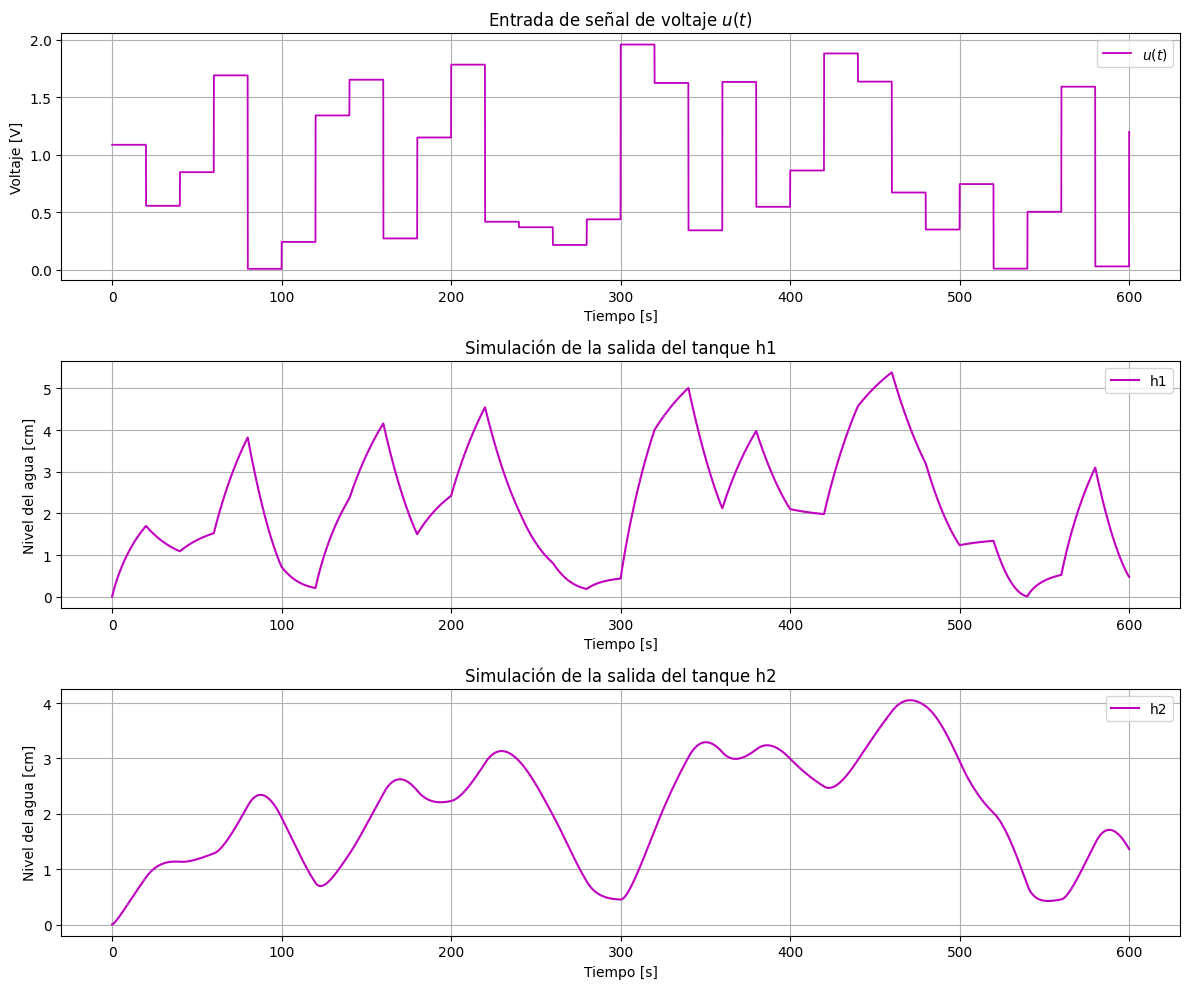

In [9]:
# Figura para visualizar las señales de entrada y salida del sistema.
plt.figure(figsize=(12, 10))

# Subgráfica 1: Señal de entrada de control (voltaje de la bomba).
plt.subplot(3, 1, 1)
plt.plot(t_full, u_full, 'm', linewidth=1.3, label='$u(t)$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title(f'Entrada de señal de voltaje $u(t)$')
plt.legend()
plt.grid(True)

# Subgráfica 2: Nivel del agua del Tanque 1.
plt.subplot(3, 1, 2)
plt.plot(t_full, h1_full * 100, 'm', linewidth=1.5, label='h1') # (Convertido a cm)
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('Simulación de la salida del tanque h1')
plt.legend()
plt.grid(True)

# Subgráfica 3: Nivel del agua del Tanque 2.
plt.subplot(3, 1, 3) # Tercera posición.
plt.plot(t_full, h2_full * 100, 'm', linewidth=1.5, label='h2') # (convertido a cm).
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('Simulación de la salida del tanque h2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 💾 Preparación de Datos para la Red Neuronal Informada por Físicas (PINN)

Este bloque organiza los datos de la simulación no lineal en los formatos requeridos para el entrenamiento de una PINN. La PINN requiere dos conjuntos de información:
1. Las **observaciones** $(\mathbf{X}_{\text{train}}, \mathbf{Y}_{\text{train}})$ para la pérdida de datos (MSE).
2. Los **puntos de colocación** $(\mathbf{t}_{\text{collocation}}, \mathbf{u}_{\text{collocation}})$ para la pérdida residual de la EDO.

### Conjunto de Entrenamiento (Datos)

El sistema de tanques es un mapeo donde la evolución del estado $\mathbf{h}(t)$ depende del tiempo $t$ y de la entrada $u(t)$.

| Variable | Contenido | Dimensión | Propósito |
| :--- | :--- | :--- | :--- |
| **$\mathbf{X}_{\text{train}}$** | $[t, u(t)]$ | $(N_{\text{Total}}, 2)$ | Vector de entradas para la red. |
| **$\mathbf{Y}_{\text{train}}$** | $[h_1(t), h_2(t)]$ | $(N_{\text{Total}}, 2)$ | Vector de salidas observadas (etiquetas). |

### Puntos de Colocación

Los **puntos de colocación** son los lugares en el dominio de tiempo donde se impone el cumplimiento de la EDO (pérdida residual). En este caso, se utiliza todo el dominio de tiempo de la simulación.

* **$\mathbf{t}_{\text{collocation}}$:** Vector de tiempo $t$ en el cual se calcularán las derivadas $\frac{\partial \mathbf{h}}{\partial t}$ y la pérdida de la EDO.
* **$\mathbf{u}_{\text{collocation}}$:** Vector de la entrada $u(t)$ correspondiente a $\mathbf{t}_{\text{collocation}}$.

> **Nota:** En este enfoque, los puntos de colocación coinciden con los puntos de observación, lo que simplifica la estructura de datos.

In [10]:
# Variables de entrada (X_train): [tiempo, entrada u]
X_train = np.hstack([t_full[:, None], u_full[:, None]])

# Variables de salida (Y_train): [h1, h2]
Y_train = np.hstack([h1_full[:, None], h2_full[:, None]])

# Puntos de colocación para la pérdida de la física (Tiempo (t) y entrada (u))
t_collocation = t_full[:, None]
u_collocation = u_full[:, None]

print("Verificación de conjuntos de datos para la PINN:")
print(f"Número total de la simulación: {N_TOTAL}")
print(f"X_train (Entrada [t, u]): {X_train.shape}")
print(f"Y_train (Observación [h1, h2]): {Y_train.shape}")
print(f"t_collocation (Tiempo para pérdida residual): {t_collocation.shape}")

Verificación de conjuntos de datos para la PINN:
Número total de la simulación: 12001
X_train (Entrada [t, u]): (12001, 2)
Y_train (Observación [h1, h2]): (12001, 2)
t_collocation (Tiempo para pérdida residual): (12001, 1)


# 🧠 Arquitectura de la Red Neuronal Informada por Físicas (PINN)

El modelo utiliza una arquitectura de red neuronal profunda (**DNN**) estructurada de manera aditiva para predecir los estados $\mathbf{h}(t) = [h_1(t), h_2(t)]^T$ en función del tiempo $t$ y la entrada de control $u(t)$. Esta estructura busca descomponer la solución del sistema en una parte transitoria (dependiente de $t$) y una parte forzada (dependiente de $u$).

La predicción es:
$$
\hat{\mathbf{h}}(t, u) = \mathbf{N}_{\text{dynamic}}(t) + \mathbf{L}_{\text{forcing}}(u)
$$

### Parámetros de la Red

| Parámetro | Valor | Descripción |
| :--- | :--- | :--- |
| **Entradas Dinámicas** | $1$ | El tiempo $t$. |
| **Entradas de Control** | $1$ | La entrada $u(t)$ (voltaje). |
| **Salidas** | $2$ | Los niveles del agua $\hat{h}_1$ y $\hat{h}_2$. |
| **Capas Ocultas** | $5$ | Número de capas en la rama dinámica. |
| **Neuronas Ocultas** | $64$ | Número de neuronas por capa oculta. |
| **Activación** | $\text{SiLU}$ | Función de Activación (Sigmoid Linear Unit). |

### Estructura de ramas

#### Rama Dinámica ($\mathbf{N}_{\text{dynamic}}$)
* **Entrada:** Solo el tiempo $t$.
* **Estructura:** Capas ocultas totalmente conectadas, con $\text{SiLU}$ como función de activación.
* **Función:** Modela la solución homogénea o la respuesta transitoria y la dependencia temporal no lineal del sistema.
* **Salida de la Rama:** Mapeada a $\hat{h}_{\text{dynamic}} \in \mathbb{R}^2$ a través de una capa lineal final.

#### Rama de Forzamiento ($\mathbf{L}_{\text{forcing}}$)
* **Entrada:** Solo el control $u(t)$.
* **Estructura:** Una única capa lineal sin activación.
* **Función:** Modela la influencia lineal directa de la entrada de control, similar a la solución particular o el efecto del estado estacionario. La entrada $u(t)$ se mapea directamente a $\hat{h}_{\text{forcing}} \in \mathbb{R}^2$.

### Función Adelante (`forward`)

El método `forward` combina las predicciones de ambas ramas mediante una suma. Esta suma impone una estructura en la solución, facilitando potencialmente el aprendizaje del efecto de la entrada de control separadamente de la dinámica temporal del sistema.

In [11]:
# Dimensiones de la red
INPUT_T_SIZE = 1
INPUT_U_SIZE = 1
OUTPUT_SIZE = 2 # h1 y h2
HIDDEN_LAYERS = 5
HIDDEN_NEURONS = 64

class PINN_Aditiva_SiLU(nn.Module):
    def __init__(self, t_size, u_size, output_size, num_layers, num_neurons):
        super(PINN_Aditiva_SiLU, self).__init__()

        '''RAMA 2: Dinámica temporal (t)'''
        # Solución homogénea/transitoria.
        layers = []

        # Capa de entrada de la rama temporal
        layers.append(nn.Linear(t_size, num_neurons))
        layers.append(nn.SiLU())

        # Capas ocultas
        for _ in range(num_layers):
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.SiLU())

        self.dynamic_branch = nn.Sequential(*layers)

        # Mapeo de la salida oculta a las dos alturas (h1, h2).
        self.output_layer = nn.Linear(num_neurons, output_size)

        '''RAMA 2: Forzamiento de control (u)'''
        # Solución particular/estado estacionario.
        # Mapea la entrada de control (u) directamente a las dos alturas (h1, h2).
        self.forcing_layer = nn.Linear(u_size, output_size, bias=False)

    def forward(self, x):
        # x: [t, u].

        t_input = x[:, 0:1] # Tiempo t
        u_input = x[:, 1:2] # Control u

        # Rama dinámica (solución homogénea)
        dynamic_hidden = self.dynamic_branch(t_input)
        h_dynamic = self.output_layer(dynamic_hidden)

        # Rama de forzamiento (Solución particular)
        h_forcing = self.forcing_layer(u_input)

        # 3. Suma aditiva de las ramas
        h_pred = h_dynamic + h_forcing

        return h_pred


# Determinar el dispositivo de cómputo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instancia del modelo
model = PINN_Aditiva_SiLU(INPUT_T_SIZE, INPUT_U_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS, HIDDEN_NEURONS).to(device)
print(f"Modelo PINN de Ramas Aditivas con SiLU creado. Entradas: t={INPUT_T_SIZE}, u={INPUT_U_SIZE}")
print(model)

Modelo PINN de Ramas Aditivas con SiLU creado. Entradas: t=1, u=1
PINN_Aditiva_SiLU(
  (dynamic_branch): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): SiLU()
    (10): Linear(in_features=64, out_features=64, bias=True)
    (11): SiLU()
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (forcing_layer): Linear(in_features=1, out_features=2, bias=False)
)


# 📉 Funciones de Normalización Min-Max

La normalización de los datos de entrada y salida es un paso crucial en el entrenamiento de redes neuronales. Al escalar los datos dentro de un rango pequeño (típicamente $[0, 1]$ o $[-1, 1]$), se mejora la estabilidad y la velocidad del proceso de optimización.

Se utiliza la normalización Min-Max.

### Función `normalize_data`

Escala los datos $\mathbf{d}$ al rango $[0, 1]$ utilizando los valores mínimo ($d_{\min}$) y máximo ($d_{\max}$) de la señal:

$$
\mathbf{d}_{\text{norm}} = \frac{\mathbf{d} - d_{\min}}{d_{\max} - d_{\min}}
$$

### Función `denormalize_data`

Invierte la operación para obtener la predicción $\mathbf{d}$ en sus unidades físicas originales a partir del valor normalizado $\mathbf{d}_{\text{norm}}$:

$$
\mathbf{d} = \mathbf{d}_{\text{norm}} \cdot (d_{\max} - d_{\min}) + d_{\min}
$$

In [12]:
#Normalización Min-Max
def normalize_data(data, data_min, data_max):
    denom = data_max - data_min
    if denom == 0:
        return data
    return (data - data_min) / denom

#Denormalización inversa
def denormalize_data(data_norm, data_min, data_max):
    return data_norm * (data_max - data_min) + data_min

# 📐 Definición de Parámetros de Escala

Este bloque calcula los valores mínimo y máximo de cada variable clave: tiempo ($t$), entrada ($u$), y salidas ($h_1, h_2$). Estos límites son necesarios para aplicar la normalización Min-Max a todos los conjuntos de datos.

El uso de los límites de los datos completos asegura que la red neuronal sea entrenada y evaluada con un rango consistente.

### Estructura de Almacenamiento

Los parámetros se almacenan en el diccionario `SCALING_PARAMS`, con la siguiente estructura:

| Variable | Arreglo de Origen | Columna |
| :--- | :--- | :--- |
| **$t$ (Tiempo)** | $\mathbf{X}_{\text{train}}$ | Índice 0 |
| **$u$ (Entrada)** | $\mathbf{X}_{\text{train}}$ | Índice 1 |
| **$h_1$ (Altura 1)** | $\mathbf{Y}_{\text{train}}$ | Índice 0 |
| **$h_2$ (Altura 2)** | $\mathbf{Y}_{\text{train}}$ | Índice 1 |

In [13]:
# Estructura de diccionario para almacenar los límites Min/Max de cada variable.
SCALING_PARAMS = {}

# Parámetros para Tiempo (t)
t_min, t_max = X_train[:, 0].min(), X_train[:, 0].max()
SCALING_PARAMS['t'] = {'min': t_min, 'max': t_max}

# Parámetros para Entrada (u)
u_min, u_max = X_train[:, 1].min(), X_train[:, 1].max()
SCALING_PARAMS['u'] = {'min': u_min, 'max': u_max}

# Parámetros para Salida h1
h1_min, h1_max = Y_train[:, 0].min(), Y_train[:, 0].max()
SCALING_PARAMS['h1'] = {'min': h1_min, 'max': h1_max}

# Parámetros para Salida h2
h2_min, h2_max = Y_train[:, 1].min(), Y_train[:, 1].max()
SCALING_PARAMS['h2'] = {'min': h2_min, 'max': h2_max}

print("Parámetros de escala definidos con éxito usando el conjunto de datos completo.")

Parámetros de escala definidos con éxito usando el conjunto de datos completo.


# 🎚️ Aplicación de la Normalización Min-Max

La normalización se aplica a todos los datos de entrada y salida, incluyendo los puntos de colocación, utilizando los límites mínimos y máximos calculados previamente en `SCALING_PARAMS`. Las variables se transforman al rango $[0, 1]$:

### Reensamblaje

Una vez normalizadas, las variables de entrada ($\mathbf{t}_{\text{norm}}, \mathbf{u}_{\text{norm}}$) y de salida ($\mathbf{h}_{1,\text{norm}}, \mathbf{h}_{2,\text{norm}}$) se vuelven a apilar horizontalmente (`np.hstack`) para reconstruir los conjuntos de entrenamiento normalizados:

$$\mathbf{X}_{\text{train, norm}} = [\mathbf{t}_{\text{norm}}, \mathbf{u}_{\text{norm}}]$$
$$\mathbf{Y}_{\text{train, norm}} = [\mathbf{h}_{1,\text{norm}}, \mathbf{h}_{2,\text{norm}}]$$

La PINN será entrenada utilizando estos datos normalizados. Las derivadas $\frac{\partial \mathbf{h}}{\partial t}$ se calcularán en el espacio normalizado, lo cual requiere una regla de la cadena que será aplicada en la función de pérdida.

In [14]:
# Descomposicón de  X_train y Y_train para aplicar normalización por columna/variable.
t_train, u_train = X_train[:, 0], X_train[:, 1]   # Tiempo (t) y Entrada (u)
h1_train, h2_train = Y_train[:, 0], Y_train[:, 1] # Alturas (h1 y h2)

# Aplicación de normalización Min-Max a cada variable
t_train_norm = normalize_data(t_train, SCALING_PARAMS['t']['min'], SCALING_PARAMS['t']['max'])
u_train_norm = normalize_data(u_train, SCALING_PARAMS['u']['min'], SCALING_PARAMS['u']['max'])
h1_train_norm = normalize_data(h1_train, SCALING_PARAMS['h1']['min'], SCALING_PARAMS['h1']['max'])
h2_train_norm = normalize_data(h2_train, SCALING_PARAMS['h2']['min'], SCALING_PARAMS['h2']['max'])

# Normalización del vector de tiempo de los puntos de colocación
t_collocation_norm = normalize_data(t_collocation.flatten(), SCALING_PARAMS['t']['min'], SCALING_PARAMS['t']['max'])[:, None]

# Normalización del vector de entrada de los puntos de colocación
u_collocation_norm = normalize_data(u_collocation.flatten(), SCALING_PARAMS['u']['min'], SCALING_PARAMS['u']['max'])[:, None]

# Reensamblar los conjuntos de datos normalizados para el entrenamiento
X_train_norm = np.hstack([t_train_norm[:, None], u_train_norm[:, None]])
Y_train_norm = np.hstack([h1_train_norm[:, None], h2_train_norm[:, None]])

print("Normalización aplicada a todos los datos de entrenamiento.")

Normalización aplicada a todos los datos de entrenamiento.


# ⚡ Conversión a Tensores de PyTorch

El último paso de preparación de datos es convertir los arreglos NumPy normalizados en Tensores de PyTorch y moverlos al dispositivo de cómputo (`CPU` o `GPU`).

### Requisito Fundamental (Diferenciación Automática)
Para que PyTorch pueda calcular la derivada $\frac{\partial \mathbf{h}}{\partial t}$, la variable de diferenciación ($\mathbf{t}$) debe tener el atributo **`requires_grad=True`**.

El tensor de entrada de colocación, $\mathbf{X}_{\text{collocation, tensor}}$, se ensambla como:
$$
\mathbf{X}_{\text{collocation, tensor}} = \text{cat}(\mathbf{t}_{\text{collocation, tensor}}, \mathbf{u}_{\text{collocation, tensor}})
$$

In [15]:
# Tensores de Entrenamiento (Observaciones para Loss de Datos)
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_norm, dtype=torch.float32).to(device)

# Tensores de Colocación (para Pérdida Residual / Física)
t_collocation_tensor = torch.tensor(t_collocation_norm, dtype=torch.float32, requires_grad=True).to(device)
u_collocation_tensor = torch.tensor(u_collocation_norm, dtype=torch.float32).to(device)

X_collocation_tensor = torch.cat([t_collocation_tensor, u_collocation_tensor], dim=1)

print(f"\nConversión a tensores de PyTorch completada en el dispositivo: {device}")
print(f"X_train_tensor.shape: {X_train_tensor.shape}")
print(f"X_collocation_tensor (Para Pérdida Física).shape: {X_collocation_tensor.shape}")


Conversión a tensores de PyTorch completada en el dispositivo: cuda
X_train_tensor.shape: torch.Size([12001, 2])
X_collocation_tensor (Para Pérdida Física).shape: torch.Size([12001, 2])


# ⚖️ Función de Pérdida Física (PhysicsLoss)

Esta clase define la **Pérdida Residual** o **Pérdida Física** ($\mathcal{L}_{\text{Física}}$), la cual asegura que la solución predicha por la red neuronal ($\hat{\mathbf{h}}$) cumpla con las leyes físicas del sistema de tanques, dadas por las **EDOs No Lineales**.

La pérdida es el cuadrado de la residual de la EDO, donde la residual $R_i$ es la diferencia entre el lado izquierdo ($\frac{d\hat{h}_i}{dt}$) y el lado derecho de la ecuación.

$$
\mathcal{L}_{\text{Física}} = \text{MSE}(\mathbf{R}) = \frac{1}{N} \sum_{k=1}^{N} (R_1^2 + R_2^2)
$$

### Derivación y Regla de la Cadena

Dado que la red neuronal opera en el espacio normalizado, la derivada $\frac{d\hat{h}}{dt}$ se calcula usando la **Diferenciación Automática (AD)** y la **Regla de la Cadena**:

$$
\frac{d\hat{h}_{\text{real}}}{dt_{\text{real}}} = \frac{d\hat{h}_{\text{real}}}{dt_{\text{norm}}} \cdot \frac{dt_{\text{norm}}}{dt_{\text{real}}}
$$

Donde:
* $\frac{d\hat{h}_{\text{real}}}{dt_{\text{norm}}}$ es calculado por `torch.autograd.grad`.
* $\frac{dt_{\text{norm}}}{dt_{\text{real}}} = \frac{1}{t_{\max} - t_{\min}}$ (el inverso del rango de escala del tiempo).

### Ecuaciones de la Residual Física

Estas ecuaciones representan la diferencia entre la dinámica predicha por la red neuronal y las leyes físicas (EDOs) que rigen el sistema de dos tanques acoplados. Cuando el modelo satisface la física, las residuales $R_1$ y $R_2$ deben ser cero.

### Residual del Tanque 1 ($R_1$)

$$
R_1 = \frac{d\hat{h}_1}{dt} + \frac{a_1}{A} \sqrt{2g\hat{h}_1} - \frac{\eta u}{A}
$$

### Residual del Tanque 2 ($R_2$)

$$
R_2 = \frac{d\hat{h}_2}{dt} - \frac{a_1}{A} \sqrt{2g\hat{h}_1} + \frac{a_2}{A} \sqrt{2g\hat{h}_2}
$$

> **Nota:** Donde $\hat{h}_i$ y $u$ son las predicciones y entradas reales (denormalizadas), y el término $\frac{d\hat{h}_i}{dt}$ incluye la corrección por la regla de la cadena de la normalización. El valor $\hat{h}_i$ se utiliza de forma segura ($\hat{h}_{i, \text{safe}} = \max(\hat{h}_i, \epsilon)$) para evitar errores en la raíz cuadrada.

El término `h_safe` (`torch.max(h_real, epsilon)`) se usa para asegurar que la raíz cuadrada $\sqrt{2g\hat{h}}$ sea calculable y diferenciable.


### Salidas `None`

Cuando PyTorch calcula el gradiente de una salida (`h_real`) con respecto a una entrada (`t_norm_grad`), sigue el grafo de cómputo de la red neuronal:

1.  **Inicio (Pesos Aleatorios):** Al comienzo del entrenamiento, los pesos de la red son aleatorios.
2.  **Predicción Plana:** La red, sin entrenamiento, a menudo produce una predicción de altura ($h_1$ o $h_2$) que es casi constante o que no muestra una dependencia significativa con la variable de tiempo ($\mathbf{t}$).
3.  **Grafo Roto/Nulo:** Si la derivada $\frac{\partial h}{\partial t}$ es numéricamente cero o la dependencia es demasiado débil, PyTorch lo interpreta como inexistencia de la dependencia en el grafo de cómputo y retorna el valor especial `None` en lugar de un tensor de ceros.

La solución consiste en reemplazar explícitamente el valor `None` por un tensor de ceros (`torch.zeros_like(h_real)`), lo cual es matemáticamente consistente con el gradiente.

In [16]:
class PhysicsLoss(nn.Module):
    def __init__(self, A, a1, a2, g, eta, epsilon, SCALING_PARAMS):
        '''Cálculo de residuales de las EDO del
        sistema de dos tanques acoplados'''
        super(PhysicsLoss, self).__init__()

        # Almacenar las constantes físicas como tensores
        self.A = torch.tensor(A, dtype=torch.float32).to(device)
        self.a1 = torch.tensor(a1, dtype=torch.float32).to(device)
        self.a2 = torch.tensor(a2, dtype=torch.float32).to(device)
        self.g = torch.tensor(g, dtype=torch.float32).to(device)
        self.eta = torch.tensor(eta, dtype=torch.float32).to(device)
        self.epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device) # Evita sqrt(0)

        # Parámetros de denormalización (límites Min/Max)
        self.h1_min = torch.tensor(SCALING_PARAMS['h1']['min'], dtype=torch.float32).to(device)
        self.h1_max = torch.tensor(SCALING_PARAMS['h1']['max'], dtype=torch.float32).to(device)
        self.h2_min = torch.tensor(SCALING_PARAMS['h2']['min'], dtype=torch.float32).to(device)
        self.h2_max = torch.tensor(SCALING_PARAMS['h2']['max'], dtype=torch.float32).to(device)
        self.u_min = torch.tensor(SCALING_PARAMS['u']['min'], dtype=torch.float32).to(device)
        self.u_max = torch.tensor(SCALING_PARAMS['u']['max'], dtype=torch.float32).to(device)
        self.t_min = torch.tensor(SCALING_PARAMS['t']['min'], dtype=torch.float32).to(device)
        self.t_max = torch.tensor(SCALING_PARAMS['t']['max'], dtype=torch.float32).to(device)

    def forward(self, t_norm_grad, u_norm, h_pred_norm):
        # Separación de predicciones normalizadas
        h1_norm = h_pred_norm[:, 0:1]
        h2_norm = h_pred_norm[:, 1:2]

        # Denormalización
        u_real = self.u_min + u_norm * (self.u_max - self.u_min)
        h1_real = self.h1_min + h1_norm * (self.h1_max - self.h1_min)
        h2_real = self.h2_min + h2_norm * (self.h2_max - self.h2_min)

        # Cálculo de Derivadas con autodiferenciación
        dh1_dt_norm = grad(h1_real, t_norm_grad,
                             grad_outputs=torch.ones_like(h1_real),
                             create_graph=True,
                             allow_unused=True)[0]

        if dh1_dt_norm is None:
            dh1_dt_norm = torch.zeros_like(h1_real)

        dh2_dt_norm = grad(h2_real, t_norm_grad,
                             grad_outputs=torch.ones_like(h2_real),
                             create_graph=True,
                             allow_unused=True)[0]

        if dh2_dt_norm is None:
            dh2_dt_norm = torch.zeros_like(h2_real)

        # Corrección de la Regla de la Cadena
        t_range = self.t_max - self.t_min

        dh1_dt_real = dh1_dt_norm / t_range
        dh2_dt_real = dh2_dt_norm / t_range

        # Manejo seguro de alturas de los tanques
        h1_safe = torch.max(h1_real, self.epsilon)
        h2_safe = torch.max(h2_real, self.epsilon)

        # Cálculo de los residuales R1 y R2
        R1 = dh1_dt_real + (self.a1 / self.A) * torch.sqrt(2 * self.g * h1_safe) - (self.eta * u_real) / self.A
        R2 = dh2_dt_real - (self.a1 / self.A) * torch.sqrt(2 * self.g * h1_safe) + (self.a2 / self.A) * torch.sqrt(2 * self.g * h2_safe)

        return R1, R2

# 📉 Cálculo de la Pérdida Total ($\mathcal{L}_{\text{Total}}$)

La función `calculate_total_loss` combina las tres fuentes de información de la Red Neuronal Informada por Físicas (PINN) en una sola métrica de optimización.

La pérdida total es una suma ponderada (hiperparámetros $w_i$) de tres componentes:

$$
\mathcal{L}_{\text{Total}} = w_{\text{data}} \cdot \mathcal{L}_{\text{Data}} + w_{\text{res}} \cdot \mathcal{L}_{\text{Res}} + w_{\text{IC}} \cdot \mathcal{L}_{\text{IC}}
$$

| Componente | Sigla | Propósito | Ponderación Típica |
| :--- | :--- | :--- | :--- |
| **Pérdida de Datos** | $\mathcal{L}_{\text{Data}}$ | Mide el ajuste a las observaciones $\mathbf{Y}_{\text{train}}$. | $w_{\text{data}} = 1.0$ |
| **Pérdida Residual** | $\mathcal{L}_{\text{Res}}$ | Mide el cumplimiento de la **EDO no lineal** en los puntos de colocación. | $w_{\text{res}} = 1.0$ |
| **Pérdida de CI** | $\mathcal{L}_{\text{IC}}$ | Fuerza el cumplimiento de las **condiciones iniciales** en $t=0$. | $w_{\text{IC}} = 10.0$ |

### Pérdida Residual Detallada

La pérdida residual ($\mathcal{L}_{\text{Res}}$) se calcula:

1.  Obteniendo la predicción $\mathbf{\hat{h}}_{\text{res}} = \text{model}(\mathbf{X}_{\text{res}})$.
2.  Descomponiendo $\mathbf{X}_{\text{res}} = [\mathbf{t}_{\text{grad}}, \mathbf{u}]$.
3.  Calculando las residuales $\mathbf{R}_1$ y $\mathbf{R}_2$ utilizando la EDO:
$$
\mathcal{L}_{\text{Res}} = \text{MSE}(\mathbf{R}_1) + \text{MSE}(\mathbf{R}_2)
$$

### Pérdida de Condiciones Iniciales Detallada

La pérdida de Condiciones Iniciales ($\mathcal{L}_{\text{IC}}$) se aplica al primer punto del conjunto de entrenamiento:

$$
\mathcal{L}_{\text{IC}} = \text{MSE}(\mathbf{\hat{h}}(t=0) - \mathbf{h}_0)
$$
Donde $\mathbf{h}_0=[0, 0]^T$. Dado que todos los datos están normalizados, el objetivo $\mathbf{Y}_{\text{IC, target}}$ es el vector $[0, 0]^T$ normalizado, que sigue siendo $[0, 0]^T$. La ponderación alta ($w_{\text{IC}}=10.0$) se usa para asegurar una rápida y precisa convergencia de la solución cerca del origen.

In [17]:
def calculate_total_loss(model, physics_loss_module, X_train, Y_train, X_res, w_data=1.0, w_res=200.0, w_ic=10.0):
    # Pérdida de los datos
    h_pred_data = model(X_train)
    loss_data = torch.mean((h_pred_data - Y_train) ** 2)

    # Pérdida residual
    h_pred_res = model(X_res)
    t_res_grad = X_res[:, 0:1]
    u_res = X_res[:, 1:2]
    R1, R2 = physics_loss_module(t_res_grad, u_res, h_pred_res)
    loss_res = torch.mean(R1 ** 2) + torch.mean(R2 ** 2)

    # Pérdida de condiciones iniciales
    X_ic = X_train[0:1]
    h_pred_ic = model(X_ic)
    Y_ic_target = Y_train[0:1]
    loss_ic = torch.mean((h_pred_ic - Y_ic_target) ** 2)

    # Pérdida total
    total_loss = w_data * loss_data + w_res * loss_res + w_ic * loss_ic

    return total_loss, loss_data, loss_res, loss_ic

# 🚀 Inicialización de Módulos de Entrenamiento

Este bloque configura los componentes finales antes de iniciar el bucle de entrenamiento: la constante de estabilidad física, la asignación de hardware y la inicialización de la función de pérdida.

In [18]:
# Parámetro de estabilidad para evitar división por cero
epsilon = 1e-6

# Mover el modelo de red neuronal al dispositivo de cómputo.
model.to(device)

# Inicializar el módulo de pérdida física y moverlo al dispositivo.
physics_loss_module = PhysicsLoss(A, a1, a2, g, eta, epsilon, SCALING_PARAMS).to(device)

# Listas de historial para monitorear la convergencia durante el entrenamiento Adam.
loss_history = []
loss_data_history = []
loss_res_history = []
loss_ic_history = []

# ⚙️ Fase 1 con Optimizador Adam

La Fase 1 utiliza el optimizador **Adam** para realizar una rápida exploración global del paisaje de la pérdida, llevando los pesos del modelo a una región de baja pérdida. Adam es robusto y eficiente en las etapas iniciales de entrenamiento.

### Hiperparámetros de Pérdida

Se definen las ponderaciones para balancear la importancia de cada componente de la pérdida:

| Ponderación | Rol |
| :--- | :--- |
| **$W_{\text{DATA}}$** | Pérdida de Ajuste a Datos ($\mathcal{L}_{\text{Data}}$). |
| **$W_{\text{RES}}$** | Pérdida Residual Física ($\mathcal{L}_{\text{Res}}$). Peso elevado para forzar el cumplimiento de la EDO. |
| **$W_{\text{IC}}$** | Pérdida de Condiciones Iniciales ($\mathcal{L}_{\text{IC}}$). |

## 🧠 Algoritmo de Optimización Adam (Adaptive Moment Estimation)

Adam es un optimizador eficiente de **descenso de gradiente estocástico** que calcula **tasas de aprendizaje adaptativas** para cada parámetro, combinando las ideas de Momentum y RMSprop.

### Estimación de Momentos (Media y Varianza)

Adam mantiene estimaciones exponenciales de promedios móviles para los gradientes en el paso de tiempo $t$. Sea $g_t = \nabla_{\theta} J_t(\theta_{t-1})$ el gradiente de la función de pérdida.

| Momento | Descripción | Fórmula de Actualización |
| :--- | :--- | :--- |
| **Primer Momento** ($m_t$) | Media del gradiente (similar a Momentum). | $m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t$ |
| **Segundo Momento** ($v_t$) | Media del cuadrado del gradiente (similar a RMSprop). | $v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2$ |

Donde $\beta_1$ y $\beta_2$ son las tasas de decaimiento exponencial (típicamente $\beta_1 \approx 0.9$ y $\beta_2 \approx 0.999$).

### Corrección del Sesgo (Bias Correction)

Debido a que $m_t$ y $v_t$ se inicializan en cero, están sesgados hacia cero en las primeras iteraciones. Adam corrige este sesgo utilizando la potencia $t$ del factor de decaimiento:

| Momento Corregido | Fórmula de Corrección |
| :--- | :--- |
| **Primer Momento Corregido** ($\hat{m}_t$) | $$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$ |
| **Segundo Momento Corregido** ($\hat{v}_t$) | $$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$ |

### Actualización Final de Parámetros

La actualización del peso $\theta$ utiliza los momentos corregidos y la tasa de aprendizaje $\alpha$:

$$\theta_t = \theta_{t-1} - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t$$

Donde $\epsilon$ (una constante pequeña, ej. $10^{-8}$) se añade para estabilidad numérica (evitar división por cero). La división por $\sqrt{\hat{v}_t}$ es lo que proporciona la **adaptabilidad**, reduciendo los pasos en dimensiones con gradientes consistentemente grandes.

**Resultado Parcial:** Después de las épocas de Adam, la red habrá encontrado un conjunto de pesos que representan una solución aproximada al problema. Estos pesos se utilizan como punto de partida para la Fase 2 (L-BFGS-B).

In [19]:
# Definición de los pesos para la función de pérdida (hiperparámetros críticos)
W_DATA = 1.0
W_RES = 200.0
W_IC = 10.0

LEARNING_RATE_ADAM = 1e-3
NUM_EPOCHS_ADAM = 7500
optimizer_adam = optim.Adam(model.parameters(), lr=LEARNING_RATE_ADAM)


print(f"--- FASE 1: Iniciando entrenamiento con Adam ({NUM_EPOCHS_ADAM} épocas) ---")
for epoch in range(1, NUM_EPOCHS_ADAM + 1):
    model.train()
    optimizer_adam.zero_grad()

    # Obtener de las pérdidas
    total_loss, loss_data, loss_res, loss_ic = calculate_total_loss(
        model,
        physics_loss_module,
        X_train_tensor,
        Y_train_tensor,
        X_collocation_tensor,
        w_data=W_DATA,
        w_res=W_RES,
        w_ic=W_IC
    )

    # Retropropagación de Adam
    total_loss.backward()
    optimizer_adam.step()

    # Monitoreo y almacenamiento de historial
    if epoch % 250 == 0:
        loss_history.append(total_loss.item())
        loss_data_history.append(loss_data.item())
        loss_res_history.append(loss_res.item())
        loss_ic_history.append(loss_ic.item())

        # Impresión de progreso
        print(f"Adam Época: {epoch}/{NUM_EPOCHS_ADAM} | Total Loss: {total_loss.item():.6e} | L_D: {loss_data.item():.6e} | L_R: {loss_res.item():.6e}")

print("--- FASE 1 COMPLETADA ---")
print(f"Pérdida final de Adam: {total_loss.item():.6e}")

--- FASE 1: Iniciando entrenamiento con Adam (7500 épocas) ---
Adam Época: 250/7500 | Total Loss: 6.156370e-02 | L_D: 6.014694e-02 | L_R: 9.723233e-07
Adam Época: 500/7500 | Total Loss: 5.422828e-02 | L_D: 5.402131e-02 | L_R: 9.159986e-07
Adam Época: 750/7500 | Total Loss: 4.031495e-02 | L_D: 4.000185e-02 | L_R: 8.679040e-07
Adam Época: 1000/7500 | Total Loss: 3.321209e-02 | L_D: 3.302849e-02 | L_R: 8.531120e-07
Adam Época: 1250/7500 | Total Loss: 1.939229e-02 | L_D: 1.920916e-02 | L_R: 9.097608e-07
Adam Época: 1500/7500 | Total Loss: 3.150171e-02 | L_D: 2.759759e-02 | L_R: 9.852736e-07
Adam Época: 1750/7500 | Total Loss: 1.275067e-02 | L_D: 1.254293e-02 | L_R: 9.969568e-07
Adam Época: 2000/7500 | Total Loss: 1.119499e-02 | L_D: 1.099498e-02 | L_R: 9.996206e-07
Adam Época: 2250/7500 | Total Loss: 9.978663e-03 | L_D: 9.778386e-03 | L_R: 1.000543e-06
Adam Época: 2500/7500 | Total Loss: 1.012058e-02 | L_D: 9.841114e-03 | L_R: 1.012251e-06
Adam Época: 2750/7500 | Total Loss: 8.349323e-03 |

# ⚙️ Fase 2: Optimización con L-BFGS-B

Esta sección define y ejecuta el optimizador L-BFGS-B (*Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm with bounds*). Este optimizador se usa en la fase final (ajuste fino o *fine-tuning*) de las Redes Neuronales Informadas por Físicas (PINNs) debido a su rápida convergencia local y precisión, aprovechando la información de segundo orden.

### Configuración del Optimizador

El L-BFGS-B es un método de cuasi-Newton que aproxima la matriz Hessiana (segundas derivadas de la función de pérdida) para determinar la dirección de descenso de manera más eficiente que los métodos de primer orden (como Adam).

| Parámetro |Descripción |
| :--- | :--- |
| `lr` | Tasa de aprendizaje inicial. Se ajusta dinámicamente durante el proceso de *line search*. |
| `max_iter` | Máximo número de iteraciones de optimización. |
| `max_eval` | Máximo número de evaluaciones de la función y gradiente permitidas. |
| `history_size` | Número de pares de gradientes y pasos anteriores utilizados para aproximar la matriz Hessiana. |
| `tolerance_grad` | Tolerancia para el gradiente de la función de pérdida. |
| `line_search_fn` | Algoritmo utilizado para encontrar el tamaño de paso óptimo en cada iteración. |

### Función de Cierre (`closure`)

El optimizador L-BFGS-B requiere una función de cierre (`closure`) que realice las siguientes acciones en cada sub-evaluación:

1.  Poner los gradientes a cero (`zero_grad()`).
2.  Calcular la pérdida total (`calculate_total_loss`).
3.  Ejecutar la retropropagación (`total_loss.backward()`) para calcular los nuevos gradientes.
4.  Retornar el valor de la pérdida.

## 🧠 Algoritmo L-BFGS-B (Optimización de Segundo Orden)

El algoritmo **L-BFGS-B** (*Limited-memory Broyden–Fletcher–Goldfarb–Shanno with bounds*) es un método de optimización de **cuasi-Newton** (segundo orden) diseñado para minimizar funciones objetivo (como la función de pérdida de una PINN) con alta precisión y eficiencia. Es una variante del método BFGS optimizada para el manejo de un gran número de parámetros.

### Principio de Funcionamiento

L-BFGS-B busca el mínimo local de una función $L(\theta)$ siguiendo la dirección definida por la aproximación de la curvatura de la función, dada por la inversa de la matriz Hessiana.

### Dirección de Descenso

La dirección de paso $\mathbf{p}_k$ en la iteración $k$ se calcula mediante la relación de Newton:

$$\mathbf{p}_k = -H_k^{-1} \nabla L(\theta_k)$$

Donde:
* $H_k^{-1}$ es la **aproximación de la inversa de la matriz Hessiana** (segundas derivadas).
* $\nabla L(\theta_k)$ es el **vector gradiente** (primeras derivadas) de la función de pérdida $L$ en los parámetros $\theta_k$.

### Mecanismo de "Memoria Limitada" (L-BFGS)

El método BFGS clásico requiere almacenar la matriz Hessiana completa, lo cual es inviable para redes neuronales con millones de parámetros.

El prefijo **"L"** (Limited-memory) resuelve esto:

* **Aproximación:** L-BFGS no almacena la matriz Hessiana completa.
* **Historial:** En su lugar, almacena solo un número fijo (`history_size`, típicamente 5 a 100) de pares de información de gradientes y pasos previos $(\mathbf{s}_i, \mathbf{y}_i)$.
* **Cálculo Eficiente:** Utiliza estos pares para calcular una aproximación de $H_k^{-1}$ sobre la marcha (producto matriz-vector) de forma recursiva, reduciendo drásticamente la complejidad computacional y el uso de memoria.

$$\mathbf{s}_k = \theta_{k+1} - \theta_k$$
$$\mathbf{y}_k = \nabla L(\theta_{k+1}) - \nabla L(\theta_k)$$

## 3. 📉 Búsqueda de Línea y Convergencia

En cada paso, L-BFGS-B determina la mejor **dirección** de descenso ($\mathbf{p}_k$) y luego utiliza un algoritmo de **búsqueda de línea** (como *Strong Wolfe*) para encontrar el tamaño de paso $\alpha_k$ que minimiza la función de pérdida a lo largo de esa dirección.

El nuevo conjunto de parámetros se actualiza como:

$$\theta_{k+1} = \theta_k + \alpha_k \mathbf{p}_k$$

Este proceso garantiza una **convergencia rápida y robusta** hacia un mínimo local, siendo ideal para el refinamiento final de modelos entrenados previamente con optimizadores de primer orden (como Adam).

In [35]:
# Configuración de optimizador LBFGS
optimizer_lbfgs = optim.LBFGS(
    model.parameters(),
    lr=0.5, # Tasa de aprendizaje alta para L-BFGS-B
    max_iter=4000,
    max_eval=4000,
    history_size=50,
    tolerance_grad=1e-7,
    tolerance_change=1e-10,
    line_search_fn="strong_wolfe"
)

def closure():
    """Función de cierre requerida por el optimizador L-BFGS-B."""
    global lbfgs_eval_count
    lbfgs_eval_count += 1
    optimizer_lbfgs.zero_grad()

    # Cálculo de pérdida
    total_loss, loss_data, loss_res, loss_ic = calculate_total_loss(
        model,
        physics_loss_module,
        X_train_tensor,
        Y_train_tensor,
        X_collocation_tensor, 
        w_data=W_DATA,
        w_res=W_RES,
        w_ic=W_IC
    )

    # Retropropagación
    total_loss.backward()

    # Monitoreo
    global current_lbfgs_loss
    current_lbfgs_loss = total_loss.item()

    if lbfgs_eval_count % 100 == 0:
        print(f"L-BFGS-B Evaluación: {lbfgs_eval_count} | Loss: {total_loss.item():.6e}")

    return total_loss

print("\n--- FASE 2: Iniciando ajuste fino con L-BFGS-B (Alta Precisión) ---")
optimizer_lbfgs.step(closure)

print("\n--- FASE 2 COMPLETADA ---")
print(f"L-BFGS-B ha finalizado el ajuste fino. Pérdida final: {current_lbfgs_loss:.6e}")


--- FASE 2: Iniciando ajuste fino con L-BFGS-B (Alta Precisión) ---
L-BFGS-B Evaluación: 100 | Loss: 3.768754e-04
L-BFGS-B Evaluación: 200 | Loss: 3.597005e-04
L-BFGS-B Evaluación: 300 | Loss: 3.476502e-04
L-BFGS-B Evaluación: 400 | Loss: 3.380365e-04
L-BFGS-B Evaluación: 500 | Loss: 3.335178e-04
L-BFGS-B Evaluación: 600 | Loss: 3.291701e-04
L-BFGS-B Evaluación: 700 | Loss: 3.243881e-04
L-BFGS-B Evaluación: 800 | Loss: 3.177135e-04
L-BFGS-B Evaluación: 900 | Loss: 3.128214e-04
L-BFGS-B Evaluación: 1000 | Loss: 3.107014e-04
L-BFGS-B Evaluación: 1100 | Loss: 3.080952e-04
L-BFGS-B Evaluación: 1200 | Loss: 3.055862e-04
L-BFGS-B Evaluación: 1300 | Loss: 3.029046e-04
L-BFGS-B Evaluación: 1400 | Loss: 3.011200e-04
L-BFGS-B Evaluación: 1500 | Loss: 2.998991e-04
L-BFGS-B Evaluación: 1600 | Loss: 2.985373e-04
L-BFGS-B Evaluación: 1700 | Loss: 2.969814e-04
L-BFGS-B Evaluación: 1800 | Loss: 2.957188e-04
L-BFGS-B Evaluación: 1900 | Loss: 2.945020e-04
L-BFGS-B Evaluación: 2000 | Loss: 2.932310e-04


# ⚙️ Predicción del Modelo y Desnormalización

Este bloque de código ejecuta el modelo entrenado para generar predicciones sobre el conjunto de entrenamiento (trabajo) y convierte los resultados de vuelta a sus unidades físicas reales.

### Fórmula de Desnormalización

La reversión de la estandarización Min-Max sigue la forma:

$$\mathbf{v}_{\text{real}} = \mathbf{v}_{\text{min}} + \mathbf{v}_{\text{norm}} (\mathbf{v}_{\text{max}} - \mathbf{v}_{\text{min}})$$

Este proceso se aplica a:

* **Predicciones** de altura ($\mathbf{h}_1$, $\mathbf{h}_2$).
* **Datos Reales** de tiempo ($\mathbf{t}$) y alturas ($\mathbf{h}_1$, $\mathbf{h}_2$) para su posterior comparación y cálculo de errores.

In [36]:
model.eval()

with torch.no_grad():
  h_pred_train_norm = model(X_train_tensor).cpu().numpy()

# Denormalización de predicciones y datos reales
h1_pred_train = denormalize_data(h_pred_train_norm[:, 0], SCALING_PARAMS['h1']['min'], SCALING_PARAMS['h1']['max'])
h2_pred_train = denormalize_data(h_pred_train_norm[:, 1], SCALING_PARAMS['h2']['min'], SCALING_PARAMS['h2']['max'])

t_train_real = denormalize_data(X_train_tensor.cpu().numpy()[:, 0], SCALING_PARAMS['t']['min'], SCALING_PARAMS['t']['max'])
h1_train_real = denormalize_data(Y_train_tensor.cpu().numpy()[:, 0], SCALING_PARAMS['h1']['min'], SCALING_PARAMS['h1']['max'])
h2_train_real = denormalize_data(Y_train_tensor.cpu().numpy()[:, 1], SCALING_PARAMS['h2']['min'], SCALING_PARAMS['h2']['max'])

# 🖼️ 3. Visualización de la Dinámica No Lineal

Este bloque de código genera una figura con dos subgráficas para la **comparación visual** de la dinámica de las alturas de los tanques ($\mathbf{h}_1$ y $\mathbf{h}_2$). El objetivo es contrastar la trayectoria aprendida por la Red Neuronal Informada por Físicas (PINN) con la trayectoria real obtenida de la simulación.

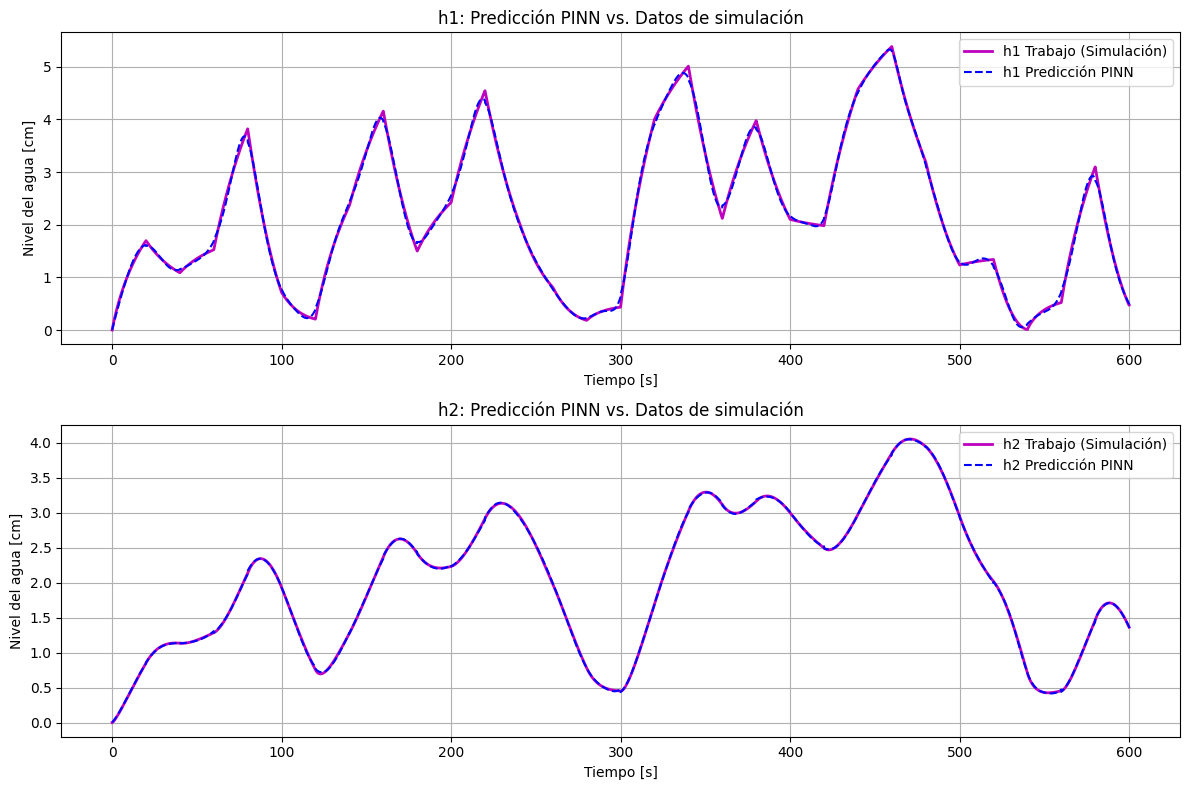

In [37]:
plt.figure(figsize=(12, 8))

# Altura h1
plt.subplot(2, 1, 1)
plt.plot(t_train_real, h1_train_real * 100, 'm', linewidth=2, label='h1 Trabajo (Simulación)')
plt.plot(t_train_real, h1_pred_train * 100, 'b--', linewidth=1.5, label='h1 Predicción PINN')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('h1: Predicción PINN vs. Datos de simulación')
plt.legend()
plt.grid(True)

# Altura h2
plt.subplot(2, 1, 2)
plt.plot(t_train_real, h2_train_real * 100, 'm', linewidth=2, label='h2 Trabajo (Simulación)')
plt.plot(t_train_real, h2_pred_train * 100, 'b--', linewidth=1.5, label='h2 Predicción PINN')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('h2: Predicción PINN vs. Datos de simulación')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 📉 4. Visualización del Error de Predicción PINN

Este bloque de código genera la visualización del error Absoluto entre la trayectoria de la simulación real (verdad fundamental) y la trayectoria predicha por el modelo PINN.

### Cálculo del Error

El vector de error ($\mathbf{e}_{\mathbf{h}_i}$) se calcula como la diferencia punto por punto entre los datos reales de la simulación ($\mathbf{h}_{\text{real}}$) y los valores predichos por la PINN ($\mathbf{h}_{\text{pred}}$).

$$\mathbf{e}_{\mathbf{h}_i} = \mathbf{h}_{i, \text{real}} - \mathbf{h}_{i, \text{pred}}$$

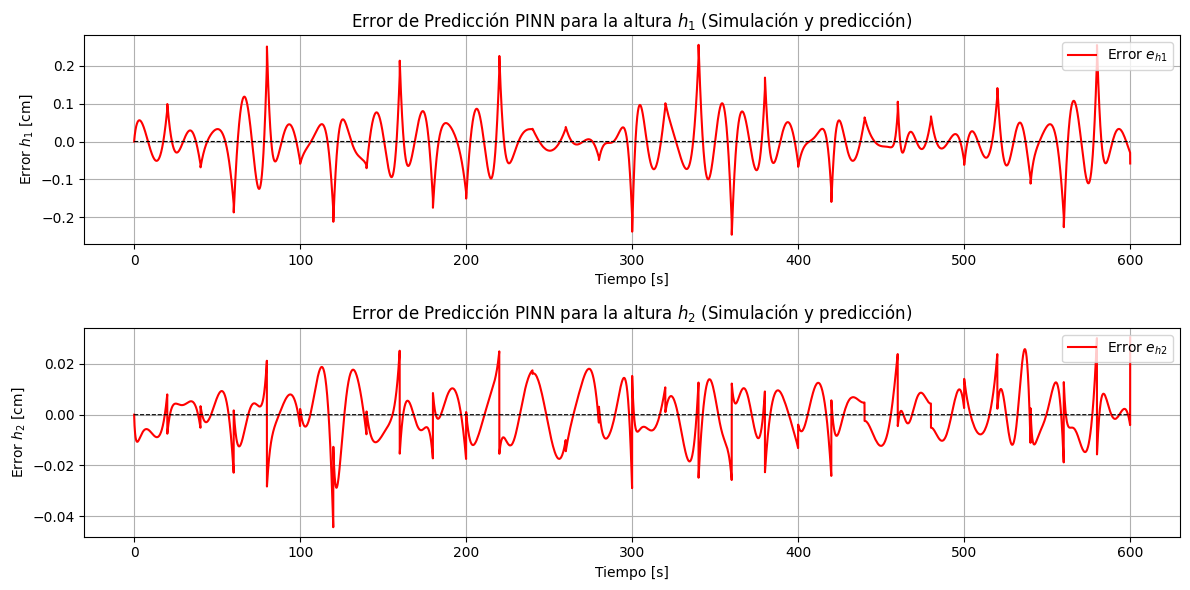

In [38]:
# Cálculo del vector de error
error_h1_pinn = h1_train_real - h1_pred_train
error_h2_pinn = h2_train_real - h2_pred_train

plt.figure(figsize=(12, 6))

# Error en el nivel del Tanque 1 (h1).
plt.subplot(2, 1, 1)
plt.plot(t_train_real, error_h1_pinn * 100, 'r', linewidth=1.5, label='Error $e_{h1}$')
plt.plot(t_train_real, np.zeros_like(t_train_real), 'k--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error $h_1$ [cm]')
plt.title('Error de Predicción PINN para la altura $h_1$ (Simulación y predicción)')
plt.legend(loc='upper right')
plt.grid(True)

# Subgráfica 2: Error en el nivel del Tanque 2 (h2).
plt.subplot(2, 1, 2)
plt.plot(t_train_real, error_h2_pinn * 100, 'r', linewidth=1.5, label='Error $e_{h2}$')
plt.plot(t_train_real, np.zeros_like(t_train_real), 'k--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error $h_2$ [cm]')
plt.title('Error de Predicción PINN para la altura $h_2$ (Simulación y predicción)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# 📊 Métricas de Evaluación de la Aproximación Lineal

El rendimiento de la predicción hecha por la Red neuronal informada por físicas se cuantifica utilizando métricas de error estándar sobre el vector de error global $\mathbf{e}_{\text{full}}$.

### Métricas Globales (sobre $T_{\text{sim}}$)

Estas métricas evalúan la precisión del modelo linealizado durante toda la simulación.

| Métrica | Sigla | Fórmula | Unidad |
| :--- | :--- | :--- | :--- |
| **Error Cuadrático Medio** | **MSE** | $$\text{MSE} = \frac{1}{2N} \sum e^2$$ | $\text{m}^2$ |
| **Raíz del Error Cuadrático Medio** | **RMSE** | $$\text{RMSE} = \sqrt{\text{MSE}}$$ | $\text{m}$ |
| **Error Absoluto Medio** | **MAE** | $$\text{MAE} = \frac{1}{2N} \sum |e|$$ | $\text{m}$ |
| **Suma del Error Cuadrático** | **SSE** | $$\text{SSE}_{\text{Global}} = \sum e^2$$ | $\text{m}^2$ |
| **RMSE Normalizado** | **NRMSE** | $$\text{NRMSE} = \frac{\text{RMSE}}{\text{Rango}(\mathbf{h}_{\text{full}})}$$ | Adimensional |

In [39]:
# Concatenación de todos los errores
error_full = np.concatenate((error_h1_pinn, error_h2_pinn))

MSE = np.mean(error_full**2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(error_full))
SSE = np.sum(error_full**2)

# Error cuadrático medio normalizado
h_full_concat = np.concatenate((h1_full, h2_full))
range_h = np.max(h_full_concat) - np.min(h_full_concat)

if range_h != 0:
    NRMSE = RMSE / range_h
else:
    NRMSE = 0.0

print("\n--------------------------- Métricas de Error de Aproximación -------------------------------")
print(f"MSE (Error Cuadrático Medio global)\t\t: {MSE:.8f} m^2 \t|({MSE*100:.8f} cm^2)")
print(f"RMSE (Raíz del Error Cuadrático Medio global)\t: {RMSE:.8f} m \t\t|({RMSE*100:.8f} cm)")
print(f"MAE (Error Absoluto Medio global)\t\t: {MAE:.8f} m \t\t|({MAE*100:.8f} cm)")
print(f"SSE (Suma del Error Cuadrático global)\t\t: {SSE:.8f} m^2 \t|({SSE*100:.8f} cm^2)")
print(f"NRMSE (Error Normalizado global)\t\t: {NRMSE:.8f} \t\t|(Adimensional)")


--------------------------- Métricas de Error de Aproximación -------------------------------
MSE (Error Cuadrático Medio global)		: 0.00000016 m^2 	|(0.00001562 cm^2)
RMSE (Raíz del Error Cuadrático Medio global)	: 0.00039528 m 		|(0.03952758 cm)
MAE (Error Absoluto Medio global)		: 0.00024341 m 		|(0.02434103 cm)
SSE (Suma del Error Cuadrático global)		: 0.00375014 m^2 	|(0.37501428 cm^2)
NRMSE (Error Normalizado global)		: 0.00734078 		|(Adimensional)


In [ ]:
# Error absoluto a almacenar
error_h1_cm = error_h1_pinn * 100
error_h2_cm = error_h2_pinn * 100

# Diccionario de columnas del CSV
datos_a_guardar = {
    'Tiempo_s': t_train_real,
    'Error_Abs_h1_cm': error_h1_cm.flatten(),
    'Error_Abs_h2_cm': error_h2_cm.flatten()
}

# Estructura de tabla
df_errores_pinn = pd.DataFrame(datos_a_guardar)

# Dataframe en formato CSV
nombre_archivo = 'errores_pinn.csv'
df_errores_pinn.to_csv(nombre_archivo, index=False)

print(f"\n✅ Errores guardados del modelo PINN guardados exitosamente en: {nombre_archivo}")
print("El archivo contiene las columnas: Tiempo_s, Error_Abs_h1_cm, Error_Abs_h2_cm.")


✅ Errores absolutos guardados del modelo PINN guardados exitosamente en: errores_absolutos_pinn.csv
El archivo contiene las columnas: Tiempo_s, Error_Abs_h1_cm, Error_Abs_h2_cm.
